In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import ConversationalRetrievalChain
from dotenv import load_dotenv
from vertexai.preview.language_models import TextEmbeddingModel
import openai

c:\Users\saide\OneDrive\Desktop\Akhil\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

1. Loading PDFs and chunking with LangChain

In [3]:
# #add PDFs

# #simple method - split by pages
# loader = PyPDFLoader("Bhagavad-gita-Swami-BG-Narasingha.pdf")
# pages = loader.load_and_split()
# print(pages[0])

# #skip to step 2 if you're using this method
# chunks = pages

In [4]:
# step 1: convert PDF to text (using PyPDF2)
import PyPDF2

def extract_text_from_pdf(pdf_path):
    text = ""
    pdf_file_obj = open(pdf_path, "rb")
    pdf_reader = PyPDF2.PdfReader(pdf_file_obj)
    for page_num in range(len(pdf_reader.pages)):
        page_obj = pdf_reader.pages[page_num]
        text += page_obj.extract_text()
    pdf_file_obj.close()
    return text

doc = extract_text_from_pdf("Bhagavad-gita-Swami-BG-Narasingha.pdf")

# step 2: Save to .txt and reopen
with open("Bhagavad-gita-Swami-BG-Narasingha.txt", 'w', encoding='utf-8') as f:
    f.write(doc)

with open("Bhagavad-gita-Swami-BG-Narasingha.txt", 'r', encoding='utf-8') as f:
    text = f.read()

# step 3: Create function to count tokens (no changes)
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# step 4: Split text into chunks (no changes)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 512,
    chunk_overlap = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])


In [5]:
type(chunks[0])

langchain_core.documents.base.Document

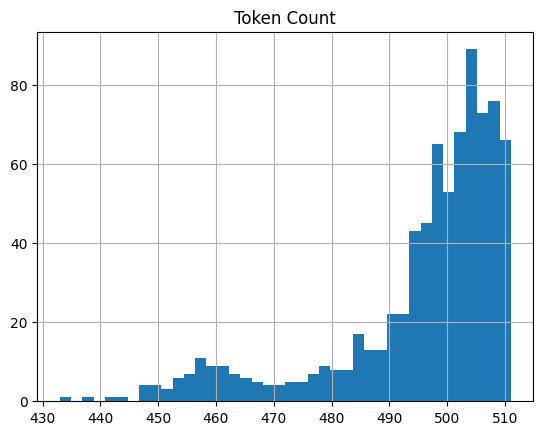

In [6]:
#Quick data visualization to ensure chunking was successful

#create a list of tokens
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

#Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

#Create a histogram of the token count distribution
df.hist(bins=40, )

#Show the plot
plt.show()

2. Embed text and store embeddings

In [7]:
try:
    response = openai.Completion.create(
        engine="davinci",
        prompt="Say this is a test",
        max_tokens=5
    )
except openai.error.OpenAIError as e:
    print(f"An error occurred: {e}")

An error occurred: No API key provided. You can set your API key in code using 'openai.api_key = <API-KEY>', or you can set the environment variable OPENAI_API_KEY=<API-KEY>). If your API key is stored in a file, you can point the openai module at it with 'openai.api_key_path = <PATH>'. You can generate API keys in the OpenAI web interface. See https://platform.openai.com/account/api-keys for details.


In [8]:
#Get embedding model
embeddings = OpenAIEmbeddings()

#create vector database
db = FAISS.from_documents(chunks, embeddings)

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors..
Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors..
Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors..
Retrying langchain.embeddings.openai.embed_wit

RateLimitError: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.

3. Setup retrieval function

In [ ]:
#check simialrity search is working
query = "Who created the universe?"

docs = db.similarity_search(query)
docs[0]